In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

In [0]:
training = pd.read_csv("/content/drive/My Drive/training.csv")

In [4]:
training.head()

,image_name,x1,x2,y1,y2
0,JPEG_20160706_121146_1000145715002.png,115,495,143,325
1,JPEG_20161119_174038_1000690577600.png,23,457,61,409
2,147444927651111470309333776-Roadster-Men-Casua...,37,601,13,470
3,147772332675720161028_161611.png,27,602,162,385
4,1473315333651DeeplearnS11638.png,60,586,174,325


In [0]:
!mkdir Images

In [6]:
cd Images

/content/Images


In [0]:
!unzip "/content/drive/My Drive/Copy of Copy of FlipkartGridStage2DataSetImages.zip"

In [11]:
cd /content

/content


In [12]:
import keras.backend as K

Using TensorFlow backend.


In [0]:
def iou(box1, box2):

    xi1 = K.maximum(box1[:, 0], box2[:, 0])
    xi2 = K.minimum(box1[:, 1], box2[:, 1])
    yi1 = K.maximum(box1[:, 2], box2[:, 2])
    yi2 = K.minimum(box1[:, 3], box2[:, 3])

    inter_area = K.maximum(xi2-xi1, 0) * K.maximum(yi2-yi1, 0)

    # Union(A,B) = Area(A) + Area(B) - Intersection(A,B)
    box1_area = (box1[:, 3] - box1[:, 2]) * (box1[:, 1] - box1[:, 0])
    box2_area = (box2[:, 3] - box2[:, 2]) * (box2[:, 1] - box2[:, 0])
    union_area = (box1_area + box2_area - inter_area)
    iou = inter_area / union_area

    return K.mean(iou)

In [0]:
def add_name(row):
  row["image_name"] = "/content/Images/images/" + row["image_name"]
  row["x1"] = row["x1"]/4
  row["x2"] = row["x2"]/4
  row["y1"] = row["y1"]/4
  row["y2"] = row["y2"]/4
  return row

In [0]:
training2 = training.apply(add_name, axis=1)

In [17]:
training2.head()

,image_name,x1,x2,y1,y2
0,/content/Images/images/JPEG_20160706_121146_10...,28.75,123.75,35.75,81.25
1,/content/Images/images/JPEG_20161119_174038_10...,5.75,114.25,15.25,102.25
2,/content/Images/images/14744492765111147030933...,9.25,150.25,3.25,117.50
3,/content/Images/images/147772332675720161028_1...,6.75,150.50,40.50,96.25
4,/content/Images/images/1473315333651DeeplearnS...,15.00,146.50,43.50,81.25


In [0]:
ind = int(len(training2) * 0.3)

val_data = training2[:ind]
train_data = training2[ind:]

In [19]:
len(val_data), len(train_data)

(4200, 9800)

In [20]:
val_data.head()

,image_name,x1,x2,y1,y2
0,/content/Images/images/JPEG_20160706_121146_10...,28.75,123.75,35.75,81.25
1,/content/Images/images/JPEG_20161119_174038_10...,5.75,114.25,15.25,102.25
2,/content/Images/images/14744492765111147030933...,9.25,150.25,3.25,117.50
3,/content/Images/images/147772332675720161028_1...,6.75,150.50,40.50,96.25
4,/content/Images/images/1473315333651DeeplearnS...,15.00,146.50,43.50,81.25


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
trainaug = ImageDataGenerator()
valaug  = ImageDataGenerator()

In [23]:
traingen = trainaug.flow_from_dataframe(dataframe=train_data, 
                                         x_col="image_name", 
                                         y_col=["x1","x2", "y1", "y2"],
                                         directory=None,target_size=(120,160),
                                          class_mode="other", batch_size=64)
valgen =  valaug.flow_from_dataframe(dataframe=val_data, 
                                         x_col="image_name", 
                                         y_col=["x1","x2", "y1", "y2"],
                                         directory=None,target_size=(120,160),
                                          class_mode="other", batch_size=64)

Found 9800 validated image filenames.
Found 4200 validated image filenames.


In [0]:
from keras import layers
from keras import models

In [0]:
cardinality = 32

In [0]:
def ResNeXt(x):
    
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
                
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        
        shortcut = y

                y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
       
        y = layers.BatchNormalization()(y)

        
        if _project_shortcut or _strides != (1, 1):
            
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(4)(x)

    return x


In [0]:
image_tensor = layers.Input(shape=(120, 160, 3))
network_output = ResNeXt(image_tensor)
model = models.Model(inputs=[image_tensor], outputs=[network_output])

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 80, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 80, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 60, 80, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
import keras

In [0]:
model.compile(optimizer= keras.optimizers.Adam(lr=.01), loss="mse", metrics= [iou])

In [31]:
hist = model.fit_generator(generator=traingen,
                          steps_per_epoch = traingen.n//traingen.batch_size,
                            validation_data = valgen,
                          validation_steps = valgen.n//valgen.batch_size,
                          epochs = 50,
                          callbacks=[keras.callbacks.ModelCheckpoint(
                          'Model_resnext.val-iou={val_iou:.2f}.val-mse={val_loss:.2f}.h5',
                          monitor='val_iou',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=False,
                           mode='max',
                              period=1
                             )])

Epoch 1/50
153/153 [==============================] - 263s 2s/step - loss: 284.2378 - iou: 0.6401 - val_loss: 818.7167 - val_iou: 0.4176
Epoch 2/50
153/153 [==============================] - 175s 1s/step - loss: 80.2959 - iou: 0.7439 - val_loss: 1013.0201 - val_iou: 0.3810
Epoch 3/50
153/153 [==============================] - 161s 1s/step - loss: 69.0291 - iou: 0.7629 - val_loss: 194.8053 - val_iou: 0.5503
Epoch 4/50
153/153 [==============================] - 159s 1s/step - loss: 62.5303 - iou: 0.7769 - val_loss: 162.4376 - val_iou: 0.6386
Epoch 5/50
153/153 [==============================] - 161s 1s/step - loss: 59.0009 - iou: 0.7786 - val_loss: 203.2890 - val_iou: 0.5863
Epoch 6/50
153/153 [==============================] - 162s 1s/step - loss: 56.8220 - iou: 0.7848 - val_loss: 637.8351 - val_iou: 0.4678
Epoch 7/50
153/153 [==============================] - 160s 1s/step - loss: 48.6268 - iou: 0.8029 - val_loss: 84.5863 - val_iou: 0.7361
Epoch 8/50
153/153 [===========================

In [32]:
hist2 = model.fit_generator(generator=traingen,
                          steps_per_epoch = traingen.n//traingen.batch_size,
                            validation_data = valgen,
                          validation_steps = valgen.n//valgen.batch_size,
                          epochs = 70,
                            initial_epoch=50,
                          callbacks=[keras.callbacks.ModelCheckpoint(
                          'Model_resnext.val-iou={val_iou:.2f}.val-mse={val_loss:.2f}.h5',
                          monitor='val_iou',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=False,
                           mode='max',
                              period=1
                             )])

Epoch 51/70
153/153 [==============================] - 168s 1s/step - loss: 5.4828 - iou: 0.9101 - val_loss: 32.2948 - val_iou: 0.8654
Epoch 52/70
153/153 [==============================] - 162s 1s/step - loss: 4.2537 - iou: 0.9194 - val_loss: 35.9046 - val_iou: 0.8531
Epoch 53/70
153/153 [==============================] - 161s 1s/step - loss: 4.3609 - iou: 0.9180 - val_loss: 36.2375 - val_iou: 0.8661
Epoch 54/70
153/153 [==============================] - 161s 1s/step - loss: 4.2285 - iou: 0.9191 - val_loss: 32.7994 - val_iou: 0.8749
Epoch 55/70
153/153 [==============================] - 162s 1s/step - loss: 4.4595 - iou: 0.9164 - val_loss: 38.1580 - val_iou: 0.8391
Epoch 56/70
153/153 [==============================] - 162s 1s/step - loss: 3.6062 - iou: 0.9251 - val_loss: 37.1533 - val_iou: 0.8696
Epoch 57/70
153/153 [==============================] - 162s 1s/step - loss: 4.2008 - iou: 0.9189 - val_loss: 30.8322 - val_iou: 0.8677
Epoch 58/70
153/153 [==============================] - 

In [33]:
hist3 = model.fit_generator(generator=traingen,
                          steps_per_epoch = traingen.n//traingen.batch_size,
                            validation_data = valgen,
                          validation_steps = valgen.n//valgen.batch_size,
                          epochs = 75,
                            initial_epoch=70,
                          callbacks=[keras.callbacks.ModelCheckpoint(
                          'Model_resnext.val-iou={val_iou:.2f}.val-mse={val_loss:.2f}.h5',
                          monitor='val_iou',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=False,
                           mode='max',
                              period=1
                             )])

Epoch 71/75
153/153 [==============================] - 167s 1s/step - loss: 2.8873 - iou: 0.9332 - val_loss: 35.3411 - val_iou: 0.8672
Epoch 72/75
153/153 [==============================] - 159s 1s/step - loss: 2.7099 - iou: 0.9339 - val_loss: 32.1596 - val_iou: 0.8781
Epoch 73/75
153/153 [==============================] - 157s 1s/step - loss: 2.8132 - iou: 0.9341 - val_loss: 36.1221 - val_iou: 0.8742
Epoch 74/75
153/153 [==============================] - 157s 1s/step - loss: 2.7835 - iou: 0.9332 - val_loss: 35.1691 - val_iou: 0.8662
Epoch 75/75
153/153 [==============================] - 158s 1s/step - loss: 2.4536 - iou: 0.9376 - val_loss: 32.2074 - val_iou: 0.8780


In [34]:
hist4 = model.fit_generator(generator=traingen,
                          steps_per_epoch = traingen.n//traingen.batch_size,
                            validation_data = valgen,
                          validation_steps = valgen.n//valgen.batch_size,
                          epochs = 80,
                            initial_epoch=75,
                          callbacks=[keras.callbacks.ModelCheckpoint(
                          'Model_resnext.val-iou={val_iou:.2f}.val-mse={val_loss:.2f}.h5',
                          monitor='val_iou',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=False,
                           mode='max',
                              period=1
                             )])

Epoch 76/80
153/153 [==============================] - 163s 1s/step - loss: 3.1871 - iou: 0.9310 - val_loss: 33.6127 - val_iou: 0.8808
Epoch 77/80
153/153 [==============================] - 157s 1s/step - loss: 2.7272 - iou: 0.9347 - val_loss: 46.0135 - val_iou: 0.8458
Epoch 78/80
153/153 [==============================] - 156s 1s/step - loss: 3.3624 - iou: 0.9301 - val_loss: 34.5247 - val_iou: 0.8629
Epoch 79/80
153/153 [==============================] - 156s 1s/step - loss: 3.3294 - iou: 0.9288 - val_loss: 33.5493 - val_iou: 0.8780
Epoch 80/80
153/153 [==============================] - 156s 1s/step - loss: 3.3652 - iou: 0.9282 - val_loss: 34.9798 - val_iou: 0.8600


In [0]:
t_loss = hist.history["loss"] + hist2.history["loss"] + hist3.history["loss"] + hist4.history["loss"]
v_loss = hist.history["val_loss"] + hist2.history["val_loss"] + hist3.history["val_loss"] + hist4.history["val_loss"]

In [0]:
t_iou = hist.history["iou"] + hist2.history["iou"] + hist3.history["iou"] + hist4.history["iou"]
v_iou = hist.history["val_iou"] + hist2.history["val_iou"] + hist3.history["val_iou"] + hist4.history["val_iou"]

In [0]:
import matplotlib.pyplot as plt

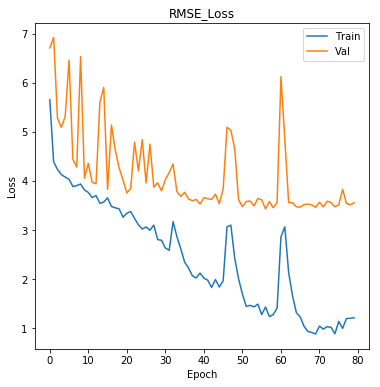

In [38]:
plt.figure(figsize=(6,6))
plt.plot(np.log(t_loss))
plt.plot(np.log(v_loss))
plt.title('RMSE_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

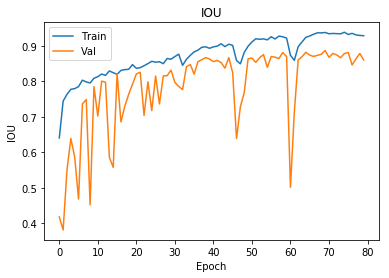

In [39]:
plt.plot(t_iou)
plt.plot(v_iou)
plt.title('IOU')
plt.ylabel('IOU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

Highest Validation IOU -  0.89